# Interactive Fuel Demand Analysis

This notebook provides interactive exploration of the diesel and gasoline demand data and forecasting models.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set plot style
plt.style.use('seaborn-v0_8')  # Updated style name
sns.set_context("notebook", font_scale=1.2)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

## 1. Data Loading and Exploration

In [5]:
# Load data
input_absolute = pd.read_csv('data/input_features_absolute.csv', parse_dates=['Date'], index_col='Date')
input_pct = pd.read_csv('data/input_features_percent_change.csv', parse_dates=['date'], index_col='date')
demand_absolute = pd.read_csv('data/demand_absolute.csv', parse_dates=['date'], index_col='date')
demand_pct = pd.read_csv('data/demand_percent_change.csv', parse_dates=['date'], index_col='date')

# Load category mapping
with open('data/category_map.pkl', 'rb') as f:
    category_map = pickle.load(f)
    
print(f"Data range: {input_absolute.index.min()} to {input_absolute.index.max()}")
print(f"Total data points: {len(input_absolute)}")
print(f"Number of features: {input_absolute.shape[1]}")

# Display category counts
category_counts = {}
for variable, category in category_map.items():
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1
        
print("\nFeatures by category:")
for category, count in category_counts.items():
    print(f"  {category}: {count} variables")

Data range: 1990-01-01 00:00:00 to 2024-12-01 00:00:00
Total data points: 420
Number of features: 35

Features by category:
  Economic: 8 variables
  Financial: 2 variables
  Industrial: 2 variables
  Labor: 7 variables
  PMI: 4 variables
  Trade: 1 variables
  Transport: 6 variables
  Price: 2 variables
  Weather: 2 variables
  Housing: 1 variables


## 2. Demand Trends Visualization

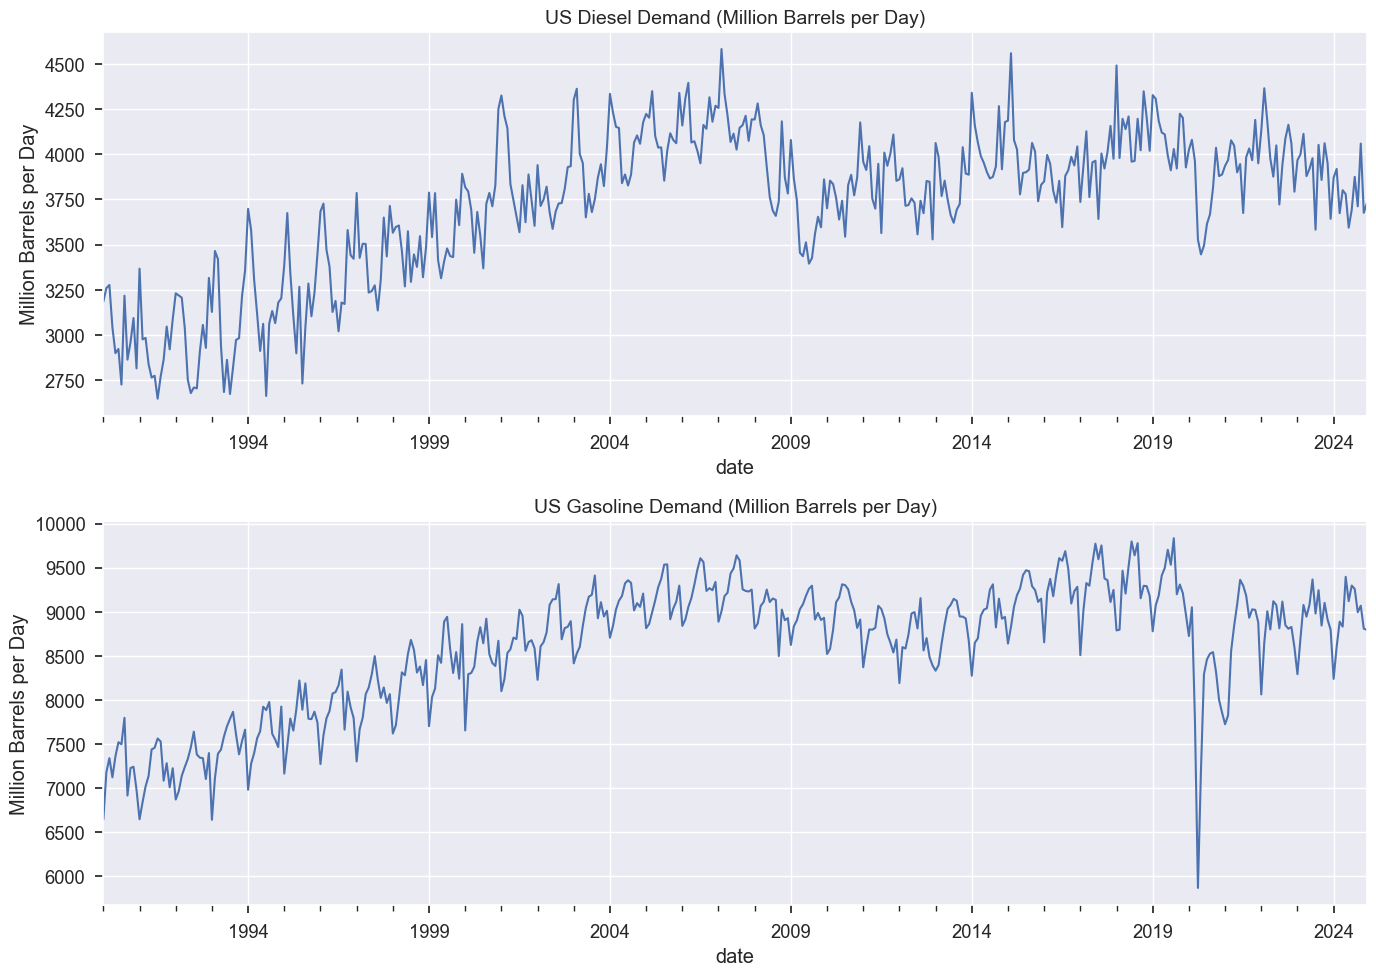

In [6]:
# Plot fuel demand trends
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Diesel demand
demand_absolute['Diesel'].plot(ax=axes[0])
axes[0].set_title('US Diesel Demand (Million Barrels per Day)', fontsize=14)
axes[0].grid(True)
axes[0].set_ylabel('Million Barrels per Day')

# Gasoline demand
demand_absolute['Gasoline'].plot(ax=axes[1])
axes[1].set_title('US Gasoline Demand (Million Barrels per Day)', fontsize=14)
axes[1].grid(True)
axes[1].set_ylabel('Million Barrels per Day')

plt.tight_layout()
plt.show()

## 3. Seasonal Patterns

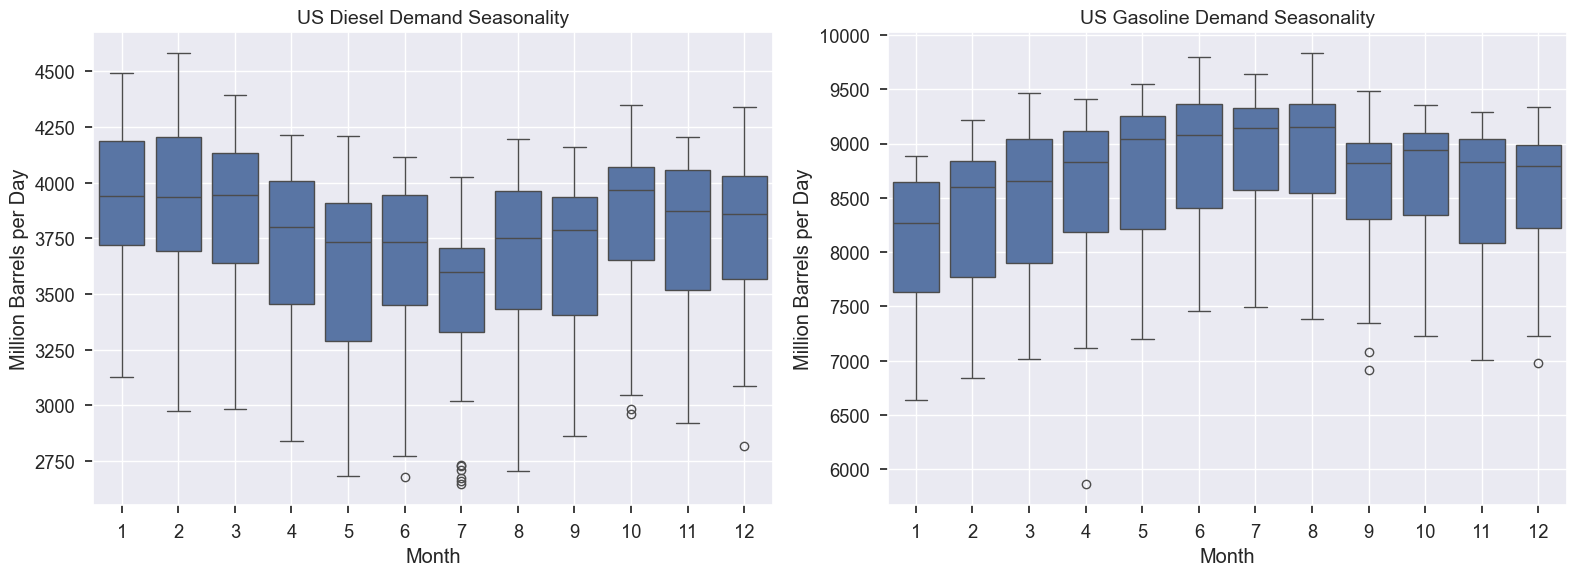

In [7]:
# Create month column for seasonal analysis
demand_monthly = demand_absolute.copy()
demand_monthly['month'] = demand_monthly.index.month
demand_monthly['year'] = demand_monthly.index.year

# Plot seasonality
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Diesel seasonality
sns.boxplot(x='month', y='Diesel', data=demand_monthly.reset_index(), ax=axes[0])
axes[0].set_title('US Diesel Demand Seasonality', fontsize=14)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Million Barrels per Day')
axes[0].grid(True)

# Gasoline seasonality
sns.boxplot(x='month', y='Gasoline', data=demand_monthly.reset_index(), ax=axes[1])
axes[1].set_title('US Gasoline Demand Seasonality', fontsize=14)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Million Barrels per Day')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 4. Year-over-Year Growth Patterns

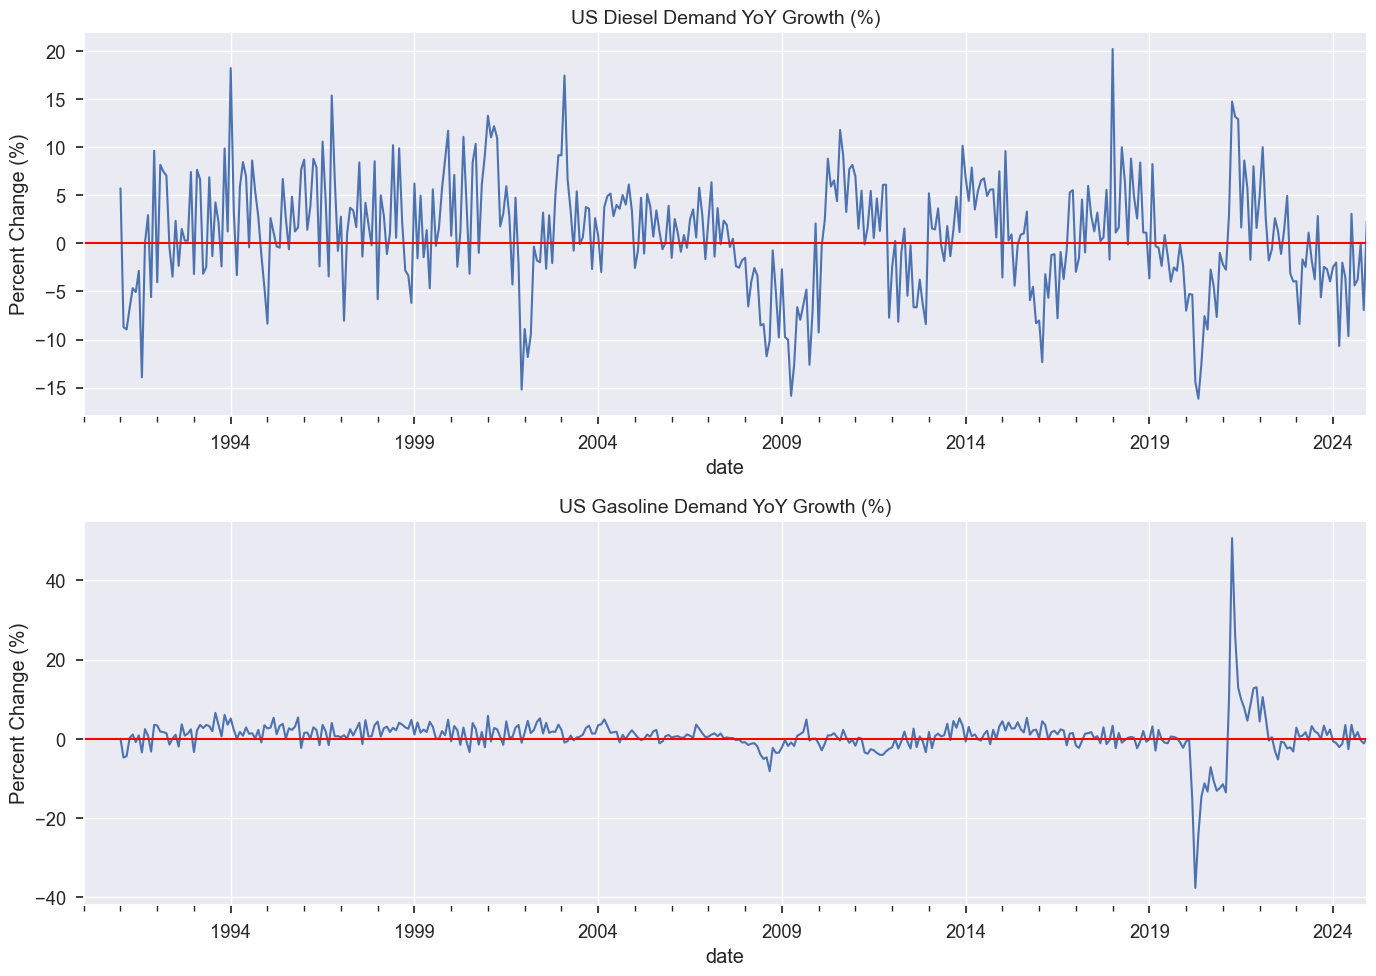

In [8]:
# Calculate year-over-year growth
yoy_growth = demand_absolute.pct_change(periods=12) * 100

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Diesel YoY growth
yoy_growth['Diesel'].plot(ax=axes[0])
axes[0].set_title('US Diesel Demand YoY Growth (%)', fontsize=14)
axes[0].axhline(y=0, color='r', linestyle='-')
axes[0].grid(True)
axes[0].set_ylabel('Percent Change (%)')

# Gasoline YoY growth
yoy_growth['Gasoline'].plot(ax=axes[1])
axes[1].set_title('US Gasoline Demand YoY Growth (%)', fontsize=14)
axes[1].axhline(y=0, color='r', linestyle='-')
axes[1].grid(True)
axes[1].set_ylabel('Percent Change (%)')

plt.tight_layout()
plt.show()

## 5. Interactive Correlation Explorer

This section allows exploration of correlations between different features and fuel demand.

In [9]:
def plot_correlation_with_demand(feature_name, fuel_type='Diesel', lag=0, use_pct=True):
    """
    Plot correlation between a feature and fuel demand
    
    Args:
        feature_name (str): Name of the feature to plot
        fuel_type (str): 'Diesel' or 'Gasoline'
        lag (int): Lag to apply to the feature (months)
        use_pct (bool): Whether to use percent change data
    """
    if use_pct:
        feature_data = input_pct[feature_name].copy()
        demand_data = demand_pct[fuel_type].copy()
        title_suffix = 'Percent Change'
    else:
        feature_data = input_absolute[feature_name].copy()
        demand_data = demand_absolute[fuel_type].copy()
        title_suffix = 'Absolute Values'
        
    # Apply lag if specified
    if lag > 0:
        feature_data = feature_data.shift(lag)
        
    # Combine data
    combined_data = pd.DataFrame({
        'Feature': feature_data,
        'Demand': demand_data
    }).dropna()
    
    # Calculate correlation
    correlation = combined_data['Feature'].corr(combined_data['Demand'])
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.scatter(combined_data['Feature'], combined_data['Demand'], alpha=0.6)
    
    # Add regression line
    m, b = np.polyfit(combined_data['Feature'], combined_data['Demand'], 1)
    plt.plot(combined_data['Feature'], m*combined_data['Feature'] + b, 'r-')
    
    # Set title and labels
    category = category_map.get(feature_name, 'Unknown')
    lag_text = f" (Lag: {lag} months)" if lag > 0 else ""
    plt.title(f'Correlation between {feature_name} and {fuel_type} Demand\n{title_suffix}{lag_text}\nCorrelation: {correlation:.4f} | Category: {category}', fontsize=12)
    plt.xlabel(feature_name)
    plt.ylabel(f'{fuel_type} Demand')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return correlation

In [10]:
# Example usage - explore correlation with GDP
plot_correlation_with_demand('GDP', fuel_type='Diesel', lag=0, use_pct=True)

KeyError: 'GDP'

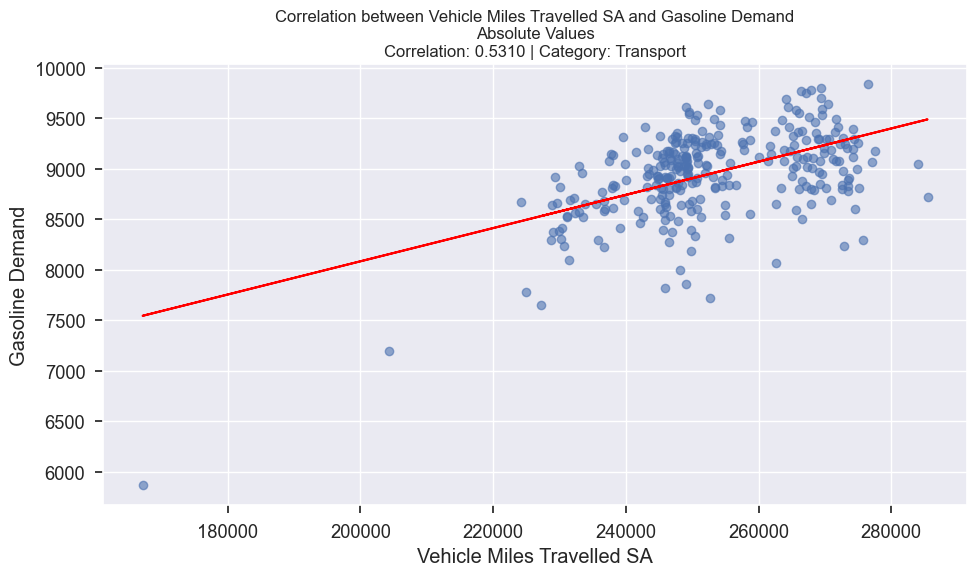

np.float64(0.530989979370808)

In [11]:
# Example usage - explore correlation with vehicle miles traveled
plot_correlation_with_demand('Vehicle Miles Travelled SA', fuel_type='Gasoline', lag=0, use_pct=False)

## 6. Top Predictor Analysis

This section explores the top predictors for diesel and gasoline demand.

Top 10 features correlated with Diesel demand (absolute values):


Industrial Production SA                     0.855361
ATA Truck Tonnage Index                      0.723632
Disposable Personal Income (Real)            0.657347
Cass Corp Freight Index                      0.639537
Personal Consumption of Non-Durable Goods    0.602427
Weekly Wages                                 0.601195
Weekly Payroll                               0.588551
Disposable Personal Income (Nominal)         0.587124
Producer Price Index                         0.575071
U.S. Gasoline - Average Retail               0.566038
dtype: float64


Top 10 features correlated with Gasoline demand (absolute values):


Industrial Production SA             0.848684
Airline Load Factor                  0.736684
ATA Truck Tonnage Index              0.699343
Number of Flights                    0.697828
Airline Seat Miles                   0.671234
Disposable Personal Income (Real)    0.635009
Cass Corp Freight Index              0.625377
Weekly Payroll                       0.598503
U.S. Gasoline - Average Retail       0.596433
Weekly Wages                         0.592115
dtype: float64


Top 10 features correlated with Diesel demand changes:


ISM Services Employment                      0.160226
Heating Degree Days                          0.158989
ATA Truck Tonnage Index                      0.152735
Personal Consumption of Non-Durable Goods    0.105372
Industrial Production SA                     0.101802
ISM Composite                                0.076128
Number of Flights                            0.071050
Vehicle Miles Travelled SA                   0.062029
Cass Corp Freight Index                      0.039874
Airline Seat Miles                           0.028721
dtype: float64


Top 10 features correlated with Gasoline demand changes:


Airline Load Factor                          0.718840
Vehicle Miles Travelled SA                   0.588336
Number of Flights                            0.459568
Weekly Payroll                               0.453253
Airline Seat Miles                           0.451057
Industrial Production SA                     0.408137
Personal Consumption of Non-Durable Goods    0.380917
ISM Services Employment                      0.285238
ISM Composite                                0.281601
Cooling Degree Days                          0.258634
dtype: float64

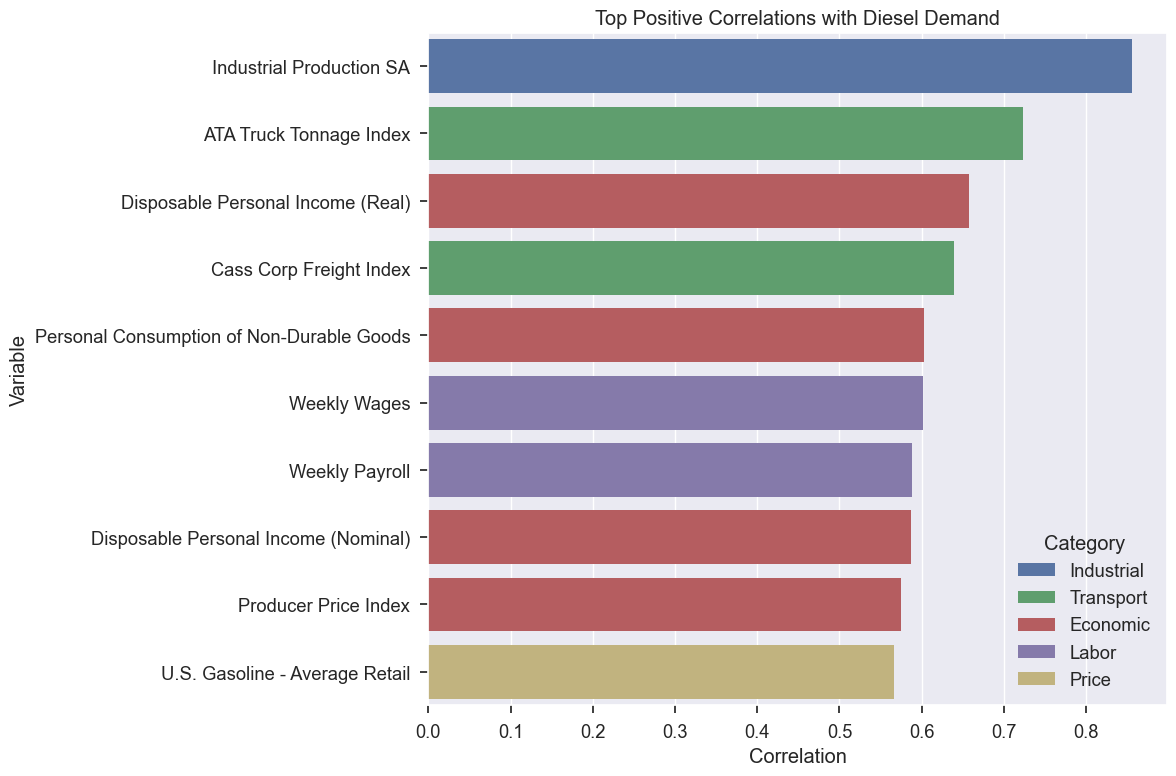

In [12]:
# Calculate correlations with demand
abs_corr_diesel = input_absolute.corrwith(demand_absolute['Diesel']).sort_values(ascending=False)
abs_corr_gasoline = input_absolute.corrwith(demand_absolute['Gasoline']).sort_values(ascending=False)

pct_corr_diesel = input_pct.corrwith(demand_pct['Diesel']).sort_values(ascending=False)
pct_corr_gasoline = input_pct.corrwith(demand_pct['Gasoline']).sort_values(ascending=False)

# Display top correlations
print("Top 10 features correlated with Diesel demand (absolute values):")
display(abs_corr_diesel.head(10))

print("\nTop 10 features correlated with Gasoline demand (absolute values):")
display(abs_corr_gasoline.head(10))

print("\nTop 10 features correlated with Diesel demand changes:")
display(pct_corr_diesel.head(10))

print("\nTop 10 features correlated with Gasoline demand changes:")
display(pct_corr_gasoline.head(10))

# Plot top 10 correlations for diesel
abs_corr_diesel_df = abs_corr_diesel.reset_index()
abs_corr_diesel_df.columns = ['Variable', 'Correlation']
abs_corr_diesel_df['Category'] = abs_corr_diesel_df['Variable'].map(category_map)

plt.figure(figsize=(12, 8))
top_positive = abs_corr_diesel_df.nlargest(10, 'Correlation')
sns.barplot(x='Correlation', y='Variable', hue='Category', data=top_positive)
plt.title('Top Positive Correlations with Diesel Demand')
plt.tight_layout()
plt.show()

## 7. Cross-Correlation Analysis

This section examines cross-correlations to identify leading indicators.

Top leading indicators for Diesel demand:


,Variable,Category,Optimal_Lag,Max_Correlation,Abs_Correlation
0,Weekly Payroll,Labor,4,0.314788,0.314788
1,Cooling Degree Days,Weather,0,-0.259703,0.259703
2,Number of Flights,Transport,4,-0.255604,0.255604
3,Airline Seat Miles,Transport,4,-0.244638,0.244638
4,Heating Degree Days,Weather,11,0.232589,0.232589
5,Avg. Weekly Hours (All private),Labor,12,-0.227330,0.227330
6,ATA Truck Tonnage Index,Transport,10,-0.212239,0.212239
7,S&P Case Shiller Home Index,Housing,4,0.173602,0.173602
8,Continuing Claims,Labor,4,-0.167739,0.167739
9,ISM Services Employment,PMI,0,0.160226,0.160226


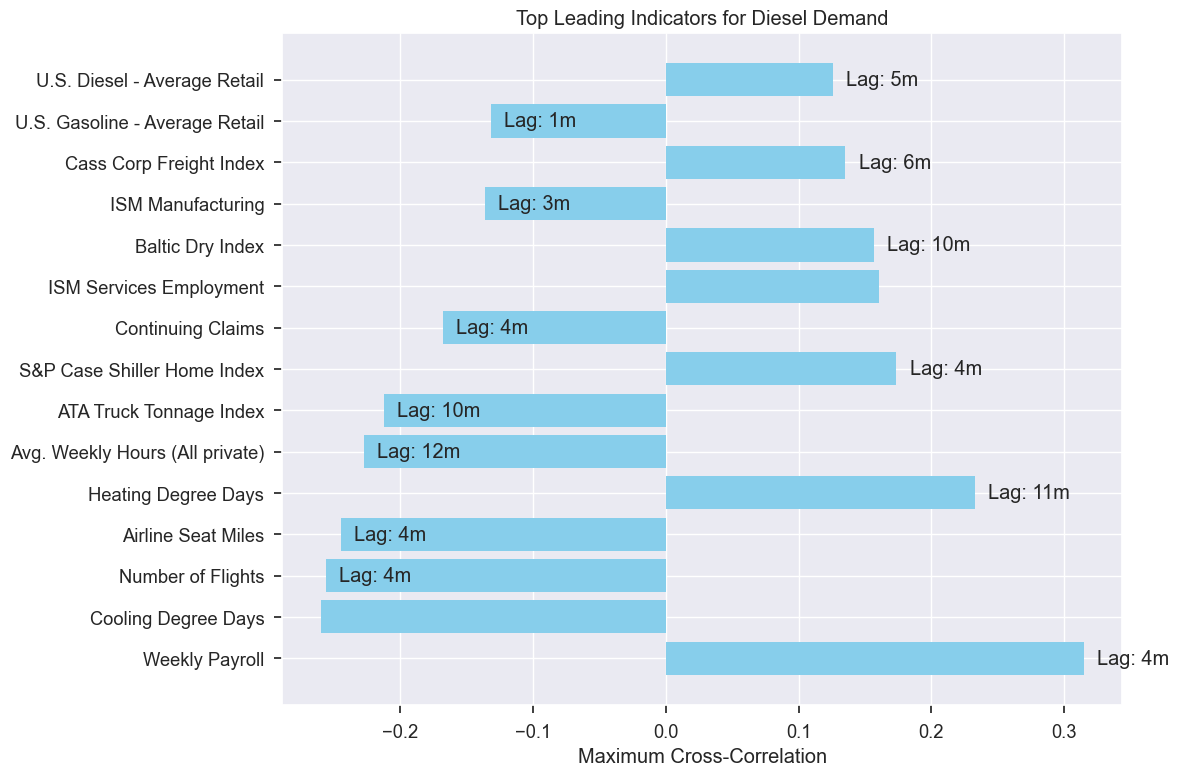

In [13]:
from scipy import stats

def calculate_cross_correlations(target_fuel='Diesel', max_lag=12, top_n=20):
    """
    Calculate cross-correlations between features and target fuel demand
    
    Args:
        target_fuel (str): 'Diesel' or 'Gasoline'
        max_lag (int): Maximum lag in months to test
        top_n (int): Number of top features to return
        
    Returns:
        pd.DataFrame: DataFrame with cross-correlation results
    """
    # Get target series
    target_series = demand_pct[target_fuel]
    
    # Initialize results
    results = []
    
    # Calculate cross-correlations for each feature
    for column in input_pct.columns:
        feature_series = input_pct[column]
        
        # Calculate cross-correlation for different lags
        cross_corr = []
        for lag in range(max_lag + 1):
            # Shift feature series by lag
            shifted_feature = feature_series.shift(lag)
            
            # Get common indices
            common_idx = shifted_feature.dropna().index.intersection(target_series.index)
            
            if len(common_idx) > 10:  # Require at least 10 points for correlation
                corr, _ = stats.pearsonr(
                    shifted_feature.loc[common_idx],
                    target_series.loc[common_idx]
                )
                cross_corr.append(corr)
            else:
                cross_corr.append(0)  # Default if not enough data
        
        # Find max correlation and corresponding lag
        max_corr = max(cross_corr, key=abs)
        optimal_lag = cross_corr.index(max_corr)
        
        # Store results
        category = category_map.get(column, 'Unknown')
        results.append({
            'Variable': column,
            'Category': category,
            'Optimal_Lag': optimal_lag,
            'Max_Correlation': max_corr
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by absolute correlation
    results_df['Abs_Correlation'] = results_df['Max_Correlation'].abs()
    results_df = results_df.sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)
    
    # Return top N results
    return results_df.head(top_n)

# Calculate cross-correlations for diesel and gasoline
diesel_cross_corr = calculate_cross_correlations('Diesel', max_lag=12, top_n=15)
print("Top leading indicators for Diesel demand:")
display(diesel_cross_corr)

# Plot for diesel
plt.figure(figsize=(12, 8))
bars = plt.barh(diesel_cross_corr['Variable'], diesel_cross_corr['Max_Correlation'], color='skyblue')

# Add lag information to bars
for i, bar in enumerate(bars):
    lag = diesel_cross_corr.iloc[i]['Optimal_Lag']
    if lag > 0:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'Lag: {lag}m', va='center')

plt.title('Top Leading Indicators for Diesel Demand')
plt.xlabel('Maximum Cross-Correlation')
plt.tight_layout()
plt.show()

## 8. PCA Analysis

This section uses Principal Component Analysis to understand feature relationships.

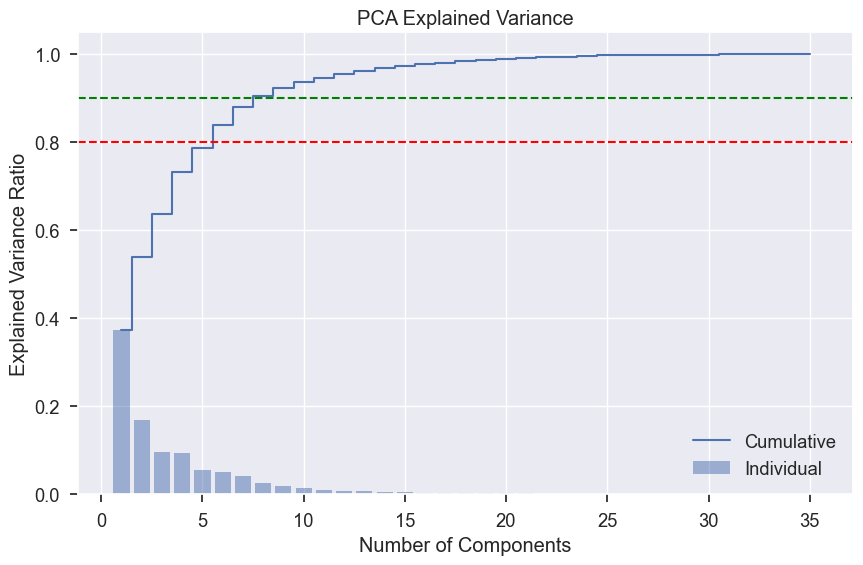

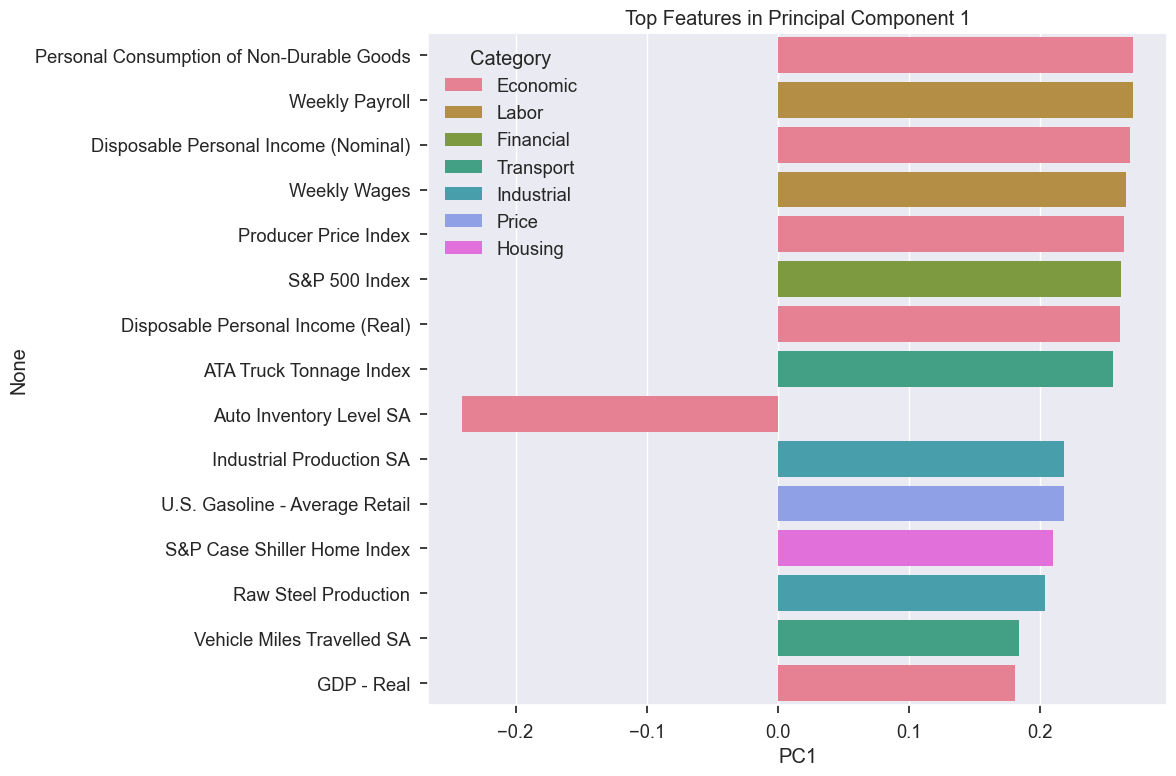

In [14]:
# Fill missing values with median for PCA
input_filled = input_absolute.fillna(input_absolute.median())

# Standardize the data
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_filled)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(input_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, label='Individual')
plt.step(range(1, len(cum_explained_variance) + 1), cum_explained_variance, where='mid', label='Cumulative')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axhline(y=0.9, color='g', linestyle='--')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Get feature loadings for top components
n_components = 3  # Number of components to analyze
loadings = pd.DataFrame(
    pca.components_.T[:, :n_components], 
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=input_filled.columns
)

# Add category information
loadings['Category'] = loadings.index.map(category_map)

# Plot feature loadings for first component
plt.figure(figsize=(12, 8))
top_features = loadings.iloc[:, 0].abs().sort_values(ascending=False).head(15).index
loadings_subset = loadings.loc[top_features, ['PC1', 'Category']]
sns.barplot(x='PC1', y=loadings_subset.index, hue='Category', data=loadings_subset.reset_index())
plt.title('Top Features in Principal Component 1')
plt.tight_layout()
plt.show()

## 9. Model Evaluation

This section loads and evaluates the trained forecasting models.

Diesel Model Performance:


,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²
Linear Regression,2.613335,4.557876,2.066580,3.988846,0.775938,0.271806
ElasticNet,3.840872,3.691063,2.861679,3.357454,0.516009,0.522443
Random Forest,1.723591,3.590918,1.311166,3.178721,0.902536,0.548006
Gradient Boosting,1.357678,2.886868,1.071896,2.463237,0.939526,0.707870
XGBoost,0.000439,2.876062,0.000299,2.313952,1.000000,0.710053



Gasoline Model Performance:


,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²
Linear Regression,1.101473,2.028656,0.878235,1.728563,0.913961,0.651318
ElasticNet,2.204381,1.863779,1.651503,1.443975,0.655397,0.705692
Random Forest,0.970315,2.281901,0.624407,1.833088,0.933232,0.558830
Gradient Boosting,0.633581,2.146474,0.494442,1.741201,0.971532,0.609641
XGBoost,0.000468,2.718052,0.000324,2.341479,1.000000,0.374066


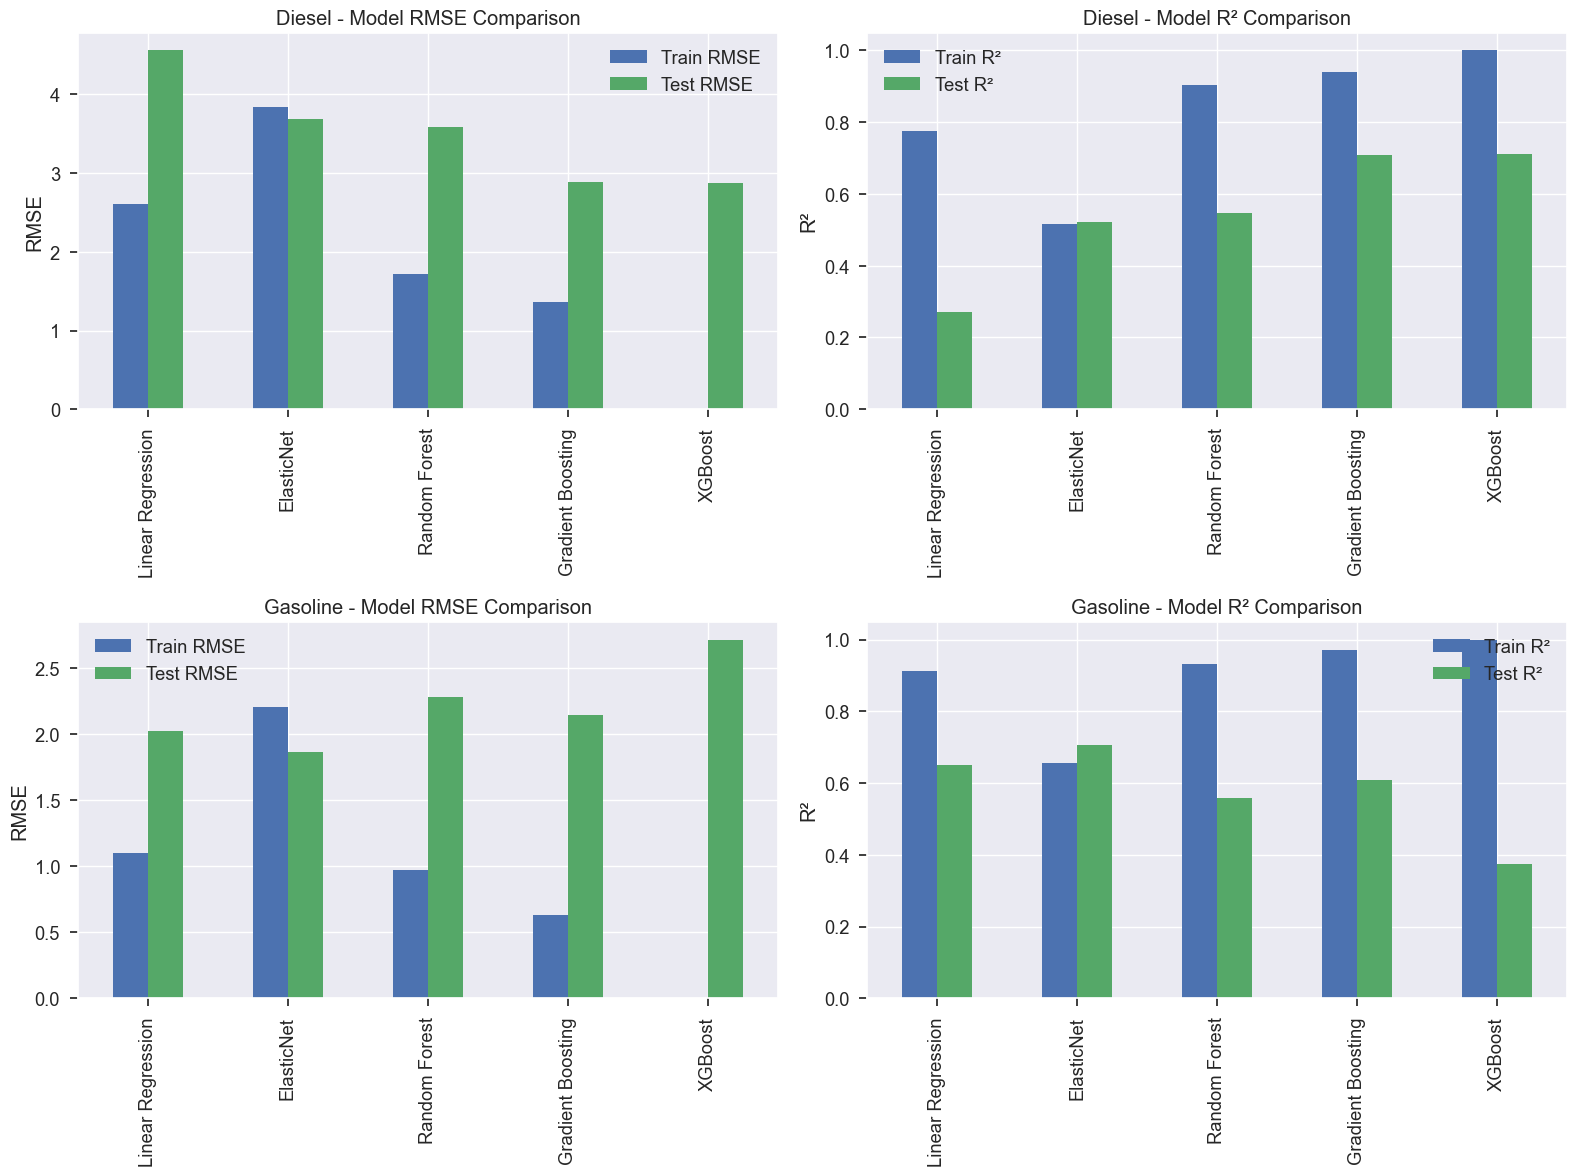

In [15]:
# Load model evaluation results
diesel_model_performance = pd.read_csv('evaluation/diesel_model_performance.csv', index_col=0)
gasoline_model_performance = pd.read_csv('evaluation/gasoline_model_performance.csv', index_col=0)

print("Diesel Model Performance:")
display(diesel_model_performance)

print("\nGasoline Model Performance:")
display(gasoline_model_performance)

# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Diesel RMSE
diesel_model_performance[['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Diesel - Model RMSE Comparison')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].grid(True, axis='y')

# Diesel R²
diesel_model_performance[['Train R²', 'Test R²']].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Diesel - Model R² Comparison')
axes[0, 1].set_ylabel('R²')
axes[0, 1].grid(True, axis='y')

# Gasoline RMSE
gasoline_model_performance[['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Gasoline - Model RMSE Comparison')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].grid(True, axis='y')

# Gasoline R²
gasoline_model_performance[['Train R²', 'Test R²']].plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Gasoline - Model R² Comparison')
axes[1, 1].set_ylabel('R²')
axes[1, 1].grid(True, axis='y')

plt.tight_layout()
plt.show()

## 10. Feature Importance Analysis

This section examines the most important features for the trained models.

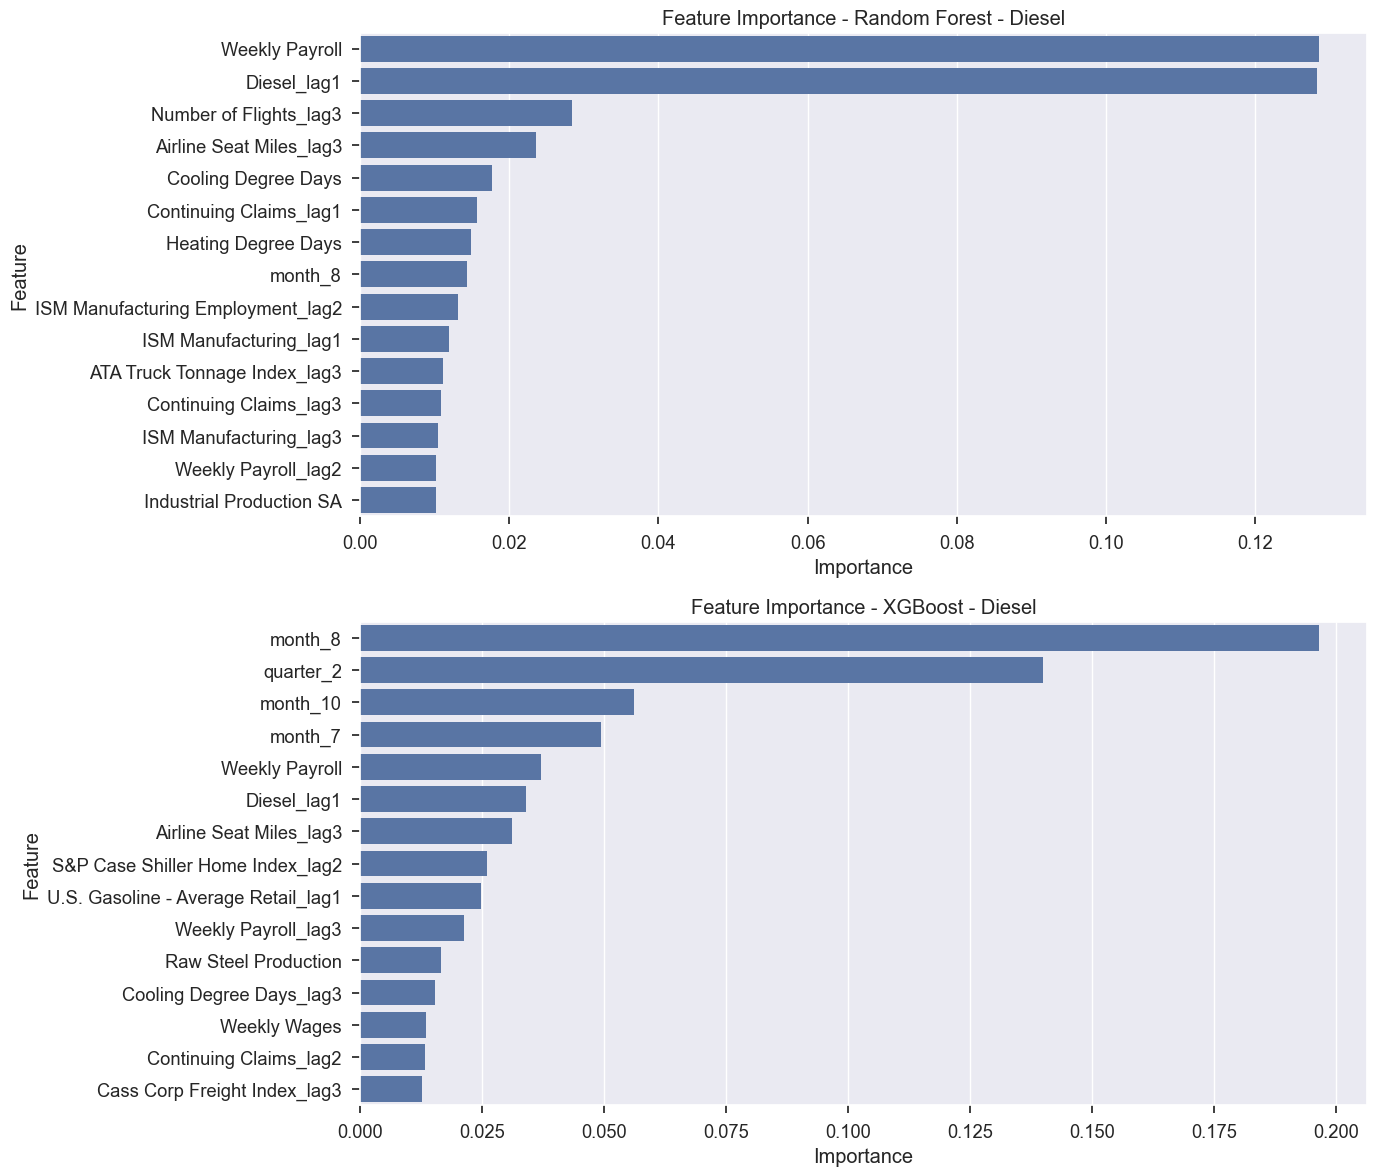

In [16]:
# Load feature importance data
try:
    diesel_rf_importance = pd.read_csv('evaluation/diesel_random_forest_feature_importance.csv')
    diesel_xgb_importance = pd.read_csv('evaluation/diesel_xgboost_feature_importance.csv')
    
    # Plot feature importance
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Random Forest importance
    top_rf = diesel_rf_importance.sort_values('Importance', ascending=False).head(15)
    sns.barplot(x='Importance', y='Feature', data=top_rf, ax=axes[0])
    axes[0].set_title('Feature Importance - Random Forest - Diesel')
    axes[0].grid(True, axis='x')
    
    # XGBoost importance
    top_xgb = diesel_xgb_importance.sort_values('Importance', ascending=False).head(15)
    sns.barplot(x='Importance', y='Feature', data=top_xgb, ax=axes[1])
    axes[1].set_title('Feature Importance - XGBoost - Diesel')
    axes[1].grid(True, axis='x')
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("Feature importance files not found. Run model_builder.py first.")

## 11. Ensemble Model Evaluation

This section evaluates the ensemble model performance.

Diesel Ensemble Model:
  RMSE: 174.2883
  MAE: 140.4922
  R²: -0.9561
  Models used: ['elasticnet', 'randomforest', 'gbm', 'xgboost']

Gasoline Ensemble Model:
  RMSE: 161.3612
  MAE: 129.8915
  R²: 0.7282
  Models used: ['elasticnet', 'randomforest', 'gbm', 'xgboost']


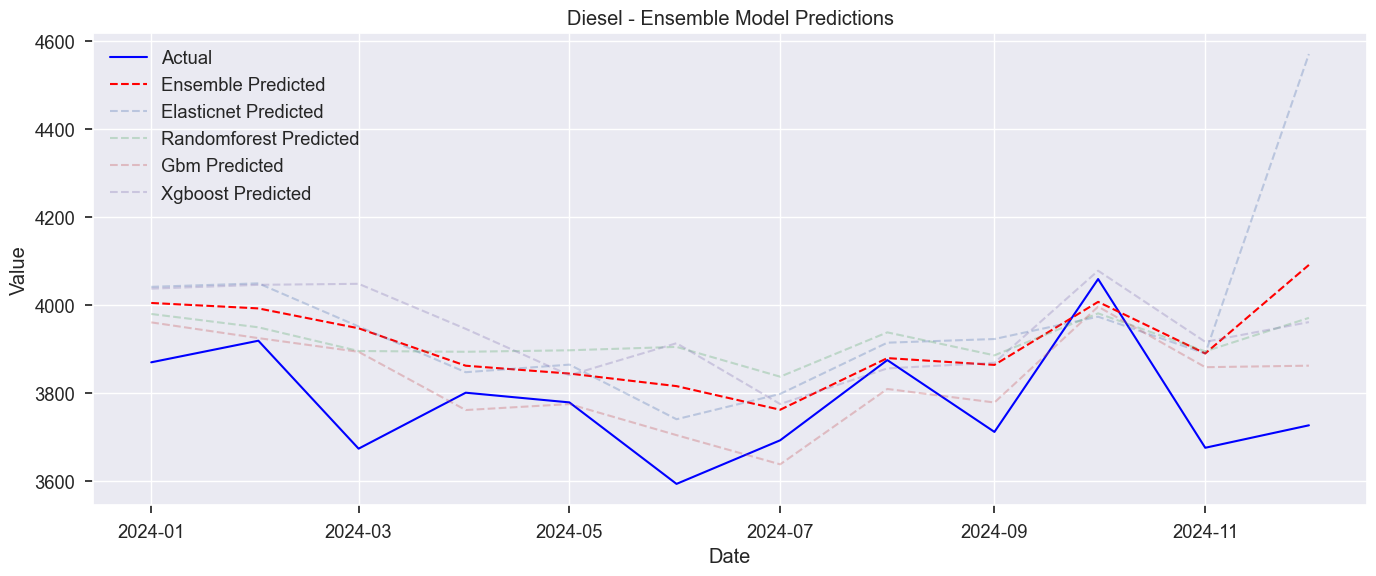

In [17]:
# Load ensemble results
try:
    with open('models/diesel_ensemble_results.pkl', 'rb') as f:
        diesel_ensemble = pickle.load(f)
        
    with open('models/gasoline_ensemble_results.pkl', 'rb') as f:
        gasoline_ensemble = pickle.load(f)
        
    # Print ensemble metrics
    print("Diesel Ensemble Model:")
    print(f"  RMSE: {diesel_ensemble['ensemble_rmse']:.4f}")
    print(f"  MAE: {diesel_ensemble['ensemble_mae']:.4f}")
    print(f"  R²: {diesel_ensemble['ensemble_r2']:.4f}")
    print(f"  Models used: {diesel_ensemble['models_used']}")
    
    print("\nGasoline Ensemble Model:")
    print(f"  RMSE: {gasoline_ensemble['ensemble_rmse']:.4f}")
    print(f"  MAE: {gasoline_ensemble['ensemble_mae']:.4f}")
    print(f"  R²: {gasoline_ensemble['ensemble_r2']:.4f}")
    print(f"  Models used: {gasoline_ensemble['models_used']}")
    
    # Plot ensemble predictions
    plt.figure(figsize=(14, 6))
    plt.plot(diesel_ensemble['y_test'].index, diesel_ensemble['y_test'], 'b-', label='Actual')
    plt.plot(diesel_ensemble['y_test'].index, diesel_ensemble['ensemble_pred'], 'r--', label='Ensemble Predicted')
    
    # Add individual model predictions
    for model_type in diesel_ensemble['models_used']:
        plt.plot(diesel_ensemble['y_test'].index, diesel_ensemble['individual_preds'][model_type], '--', alpha=0.3, label=f'{model_type.capitalize()} Predicted')
        
    plt.title('Diesel - Ensemble Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("Ensemble model files not found. Run model_builder.py first.")

## 12. Custom Scenario Analysis

This section allows for creating custom scenarios and forecasting fuel demand.

In [22]:
import pandas as pd
import pickle
import numpy as np
import os

def predict_scenario(model_type='xgboost', fuel_type='Diesel', scenario_data=None):
    """
    Make predictions using a scenario
    
    Args:
        model_type (str): Type of model to use ('xgboost', 'randomforest', 'gbm', 'elasticnet', or 'ensemble')
        fuel_type (str): 'Diesel' or 'Gasoline'
        scenario_data (dict): Dictionary with scenario data for features
        
    Returns:
        float: Predicted demand value
    """
    # Load the model
    base_path = 'models'
    file_name = f"{fuel_type.lower()}_ensemble_results.pkl"
    model_path = os.path.join(base_path, file_name)  # Safer path construction
    
    print(f"Looking for model file at: {os.path.abspath(model_path)}")
    if not os.path.exists(model_path):
        print(f"File does not exist at {model_path}. Available files in {base_path}: {os.listdir(base_path) if os.path.exists(base_path) else 'Directory not found'}")
        print(f"Model file not found for {model_type}. Run model_builder.py first.")
        return None

    try:
        if model_type == 'ensemble':
            with open(model_path, 'rb') as f:
                ensemble_results = pickle.load(f)
                
            # Load all models used in ensemble
            models = {}
            for m_type in ensemble_results['models_used']:
                sub_model_path = os.path.join(base_path, f"{fuel_type.lower()}_{m_type}_optimized.pkl")
                if not os.path.exists(sub_model_path):
                    print(f"Sub-model file missing: {sub_model_path}")
                    return None
                with open(sub_model_path, 'rb') as f:
                    models[m_type] = pickle.load(f)
        else:
            with open(os.path.join(base_path, f"{fuel_type.lower()}_{model_type}_optimized.pkl"), 'rb') as f:
                model = pickle.load(f)
    except FileNotFoundError:
        print(f"Unexpected FileNotFoundError for {model_type}. Check file paths.")
        return None
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Create input DataFrame
    if scenario_data is None:
        try:
            latest_data = input_absolute.iloc[-1].to_dict()
            print("Using latest data as starting point.")
        except NameError:
            print("Error: 'input_absolute' is not defined. Please provide scenario_data or ensure input_absolute is available.")
            return None
    else:
        latest_data = scenario_data
    
    input_df = pd.DataFrame([latest_data])
    
    # Make prediction
    if model_type == 'ensemble':
        predictions = []
        for m_type, m in models.items():
            pred = m.predict(input_df)[0]
            predictions.append(pred)
            print(f"{m_type.capitalize()} prediction: {pred:.4f}")
        final_pred = np.mean(predictions)
    else:
        final_pred = model.predict(input_df)[0]
    
    return final_pred

# Example usage
print("Scenario Analysis:")
prediction = predict_scenario(model_type='ensemble', fuel_type='Diesel')
if prediction is not None:
    print(f"Predicted Diesel demand: {prediction:.4f} million barrels per day")
else:
    print("Prediction failed. Check error messages above.")

Scenario Analysis:
Looking for model file at: c:\Users\JRICK\OneDrive - Equinor\Documents\Dev\Product Demand Machine Learning\models\diesel_ensemble_results.pkl
Sub-model file missing: models\diesel_elasticnet_optimized.pkl
Prediction failed. Check error messages above.


## 13. Custom Feature Exploration

This section allows the user to explore the effect of changing individual features on the prediction.

In [ ]:
def explore_feature_impact(feature_name, feature_range, model_type='xgboost', fuel_type='Diesel'):
    """
    Explore the impact of changing a feature value on prediction
    
    Args:
        feature_name (str): Name of the feature to explore
        feature_range (list): Range of values to explore
        model_type (str): Type of model to use
        fuel_type (str): 'Diesel' or 'Gasoline'
    """
    # Load the model
    try:
        with open(f'models/{fuel_type.lower()}_{model_type}_optimized.pkl', 'rb') as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f"Model file not found for {model_type}. Run model_builder.py first.")
        return
    
    # Use the latest data as a starting point
    base_data = input_absolute.iloc[-1].to_dict()
    
    # Generate predictions for different feature values
    predictions = []
    for value in feature_range:
        # Create a copy of the base data
        scenario_data = base_data.copy()
        
        # Modify the feature value
        scenario_data[feature_name] = value
        
        # Create a DataFrame with the input features
        input_df = pd.DataFrame([scenario_data])
        
        # Make prediction
        pred = model.predict(input_df)[0]
        predictions.append(pred)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(feature_range, predictions, 'o-')
    plt.title(f'Impact of {feature_name} on {fuel_type} Demand\nModel: {model_type}')
    plt.xlabel(feature_name)
    plt.ylabel(f'Predicted {fuel_type} Demand')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate elasticity
    base_value = base_data[feature_name]
    base_pred = model.predict(pd.DataFrame([base_data]))[0]
    
    # Find closest value to base in feature_range
    closest_idx = min(range(len(feature_range)), key=lambda i: abs(feature_range[i] - base_value))
    
    if closest_idx < len(feature_range) - 1:
        value1 = feature_range[closest_idx]
        value2 = feature_range[closest_idx + 1]
        pred1 = predictions[closest_idx]
        pred2 = predictions[closest_idx + 1]
        
        pct_change_feature = (value2 - value1) / value1 * 100
        pct_change_demand = (pred2 - pred1) / pred1 * 100
        
        if pct_change_feature != 0:
            elasticity = pct_change_demand / pct_change_feature
            print(f"Estimated elasticity: {elasticity:.4f}")
            print(f"A 1% change in {feature_name} leads to a {elasticity:.4f}% change in {fuel_type} demand")
    
    return predictions

# Example usage - explore the impact of GDP on Diesel demand
gdp_values = np.linspace(input_absolute['GDP'].min(), input_absolute['GDP'].max(), 20)
explore_feature_impact('GDP', gdp_values, model_type='xgboost', fuel_type='Diesel')